References:
- http://www.dept.aoe.vt.edu/~cdhall/courses/aoe4140/attde.pdf
- [Magnetic Coordinate Systems](https://arxiv.org/ftp/arxiv/papers/1611/1611.10321.pdf)
- [Spacecraft Magnetic Torques](https://ntrs.nasa.gov/api/citations/19690020961/downloads/19690020961.pdf)
- [Geodetic Coordinate Conversions](https://www.oc.nps.edu/oc2902w/coord/coordcvt.pdf)

In [1]:
using LinearAlgebra, HTTP, Gumbo, DataInterpolations, Plots, DifferentialEquations

In [2]:
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/spacecraft_adcs.jl")
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/gnc.jl")
include("C:/Users/mjski/Desktop/Active-Work/git-projects/scripts/scripts/orbital_dynamics.jl")

diffeq_three_body_cr (generic function with 1 method)

# Disturbance Torque Modelling

## Magnetic Torque

In [13]:
# modelling magnetic field density
# https://ntrs.nasa.gov/api/citations/19690020961/downloads/19690020961.pdf
function harmonic_coefficients(year=2022)
    # units in nT
    return [
        -30401.2 + 14.03*(year - 1965)
        -2163.8 + 8.76*(year - 1965)
        5778.2 + 3.71*(year - 1965)
    ] .* 1e-9
end

# λ: geocentric longitude
# δ: geocentric latitude
# θ: geocentric colatitude, π/2 - δ
function B_spin_axis(R, δ; Re = 6378.0)
    g01, g11, h11 = harmonic_coefficients()

    θ = π/2 - δ
    
    return [
        ((Re / R)^3) * g01 * sin(θ)
        0
        2 * ((Re / R)^3) * g01 * cos(θ)
    ]
end

# λ: geocentric longitude
# δ: geocentric latitude
# θ: geocentric colatitude, π/2 - δ
function B_tilted_dipole(R, δ, λ; Re = 6378.0)
    g01, g11, h11 = harmonic_coefficients()
    
    θ = π/2 - δ
    Rmag = norm(R)
    
    return [
        (Re / Rmag) * (g01*sin(θ) + g11 * cos(θ) * cos(λ) + h11 * cos(θ) * sin(λ))
        -((Re / Rmag)^3) * (g11 * sin(λ) - h11 * cos(θ))
        2 * ((Re / Rmag)^3) * (g01 * cos(θ) + g11 * sin(θ) * cos(λ) + h11 * sin(θ) * sin(λ))
    ]
end

# https://www.oc.nps.edu/oc2902w/coord/coordcvt.pdf
# λ: longitude (east longitude)
# ϕ: geodetic colatitude
# ϕc: geocentric colatitude
function ecef2geocentric_latlon(x, y, z)
    λ = atan(y, x)
    
    r = sqrt(x^2 + y^2 + z^2)
    p = sqrt(x^2 + y^2)
    
    ϕc = atan(p, z)

    return π/2 - ϕc, λ 
end

function ecef2geodetic_latlon(x, y, z; iters=5)
    λ = atan(y, x)
    
    r = sqrt(x^2 + y^2 + z^2)
    p = sqrt(x^2 + y^2)
    
    ϕc = atan(p, z)
    ϕ = ϕc
    
    a = 6378.137
    esq = 6.69437999014e−3
    for _ in 1:iters
        Rn = a / sqrt(1 - esq * sin(ϕ)^2)
        h = p/cos(ϕ) - Rn
        ϕ = atan((z/p) / (1 - esq * (Rn / (Rn + h))))
    end
    
    return π/2 - ϕc, λ 
end

# local polar vectors in ECEF frame
function local_polar(R)
    x, y, z = R
    δ, λ = ecef2geocentric_latlon(x, y, z)
    
    R_BE = par_3((2*π - λ)) * par_2(δ-π/2)
    
    x̂B = R_BE * [1, 0, 0]
    ŷB = R_BE * [0, 1, 0]
    ẑB = R_BE * [0, 0, 1]
    
    return x̂B, ŷB, ẑB
end

# returns magnetic field density vectors
function magnetic_field_density(R)
    x, y, z = R
    x̂B, ŷB, ẑB = local_polar(R)
    
    δ, λ = ecef2geocentric_latlon(x, y, z)
    Bx, By, Bz = B_tilted_dipole(R, δ, λ)
    
    return [Bx * x̂B, By * ŷB, Bz * ẑB]
end

# function polar2ecef(R, v1, v2, v3)
#     x, y, z = R
#     δ, λ = ecef2geocentric_latlon(x, y, z)
    
#     R_EB = (par_3((2*π - λ)) * par_2(δ-π/2))'
    
#     ex = [(R_EB * v1)[1], 0.0, 0.0]
#     ey = [0.0, (R_EB * v2)[2], 0.0]
#     ez = [0.0, 0.0, (R_EB * v3)[3]]
    
#     return [ex, ey, ez]
# end

function polar2ecef(R, v1, v2, v3)
    x, y, z = R
    δ, λ = ecef2geocentric_latlon(x, y, z)
    
    R_EB = par_2(π/2 - δ) * par_3(λ - 2*π)
    
    ex = [(R_EB * v1)[1], 0.0, 0.0]
    ey = [0.0, (R_EB * v2)[2], 0.0]
    ez = [0.0, 0.0, (R_EB * v3)[3]]
    
    return ex, ey, ez
end

# function magnetic_torque(magnetic_moment, R, C_BN)
#     Bx, By, Bz = magnetic_field_density(R)
#     Ex, Ey, Ez = polar2ecef(R, Bx, By, Bz)
#     B = [Ex[1], Ey[2], Ez[3]]
    
#     return C_BN * (magnetic_moment × B)
# end

function magnetic_torque(magnetic_moment, R, C_BN)
    Bx, By, Bz = magnetic_field_density(R)
    Ex, Ey, Ez = polar2ecef(R, Bx, By, Bz)
    B = [Ex[1], Ey[2], Ez[3]]
    
    return C_BN * (magnetic_moment × B)
end

magnetic_torque (generic function with 1 method)

In [80]:
magnetic_torque([5,5,5], [6578, 6578, 100], I(3))

3-element Vector{Float64}:
  6.8289105021837385e-6
 -0.00011017946827464396
  0.00010335055777246022

In [82]:
magnetic_torque2([5,5,5], [6578, 6578, 100], I(3)) .== magnetic_torque([5,5,5], [6578, 6578, 100], I(3))

3-element BitVector:
 1
 1
 1

## Aerodynamic Torque

In [4]:
# density interpolation
r = HTTP.request("GET", "http://www.braeunig.us/space/atmos.htm")

# parsing and getting body
r_parsed = parsehtml(String(r.body))
body = r_parsed.root[2]

# table 2, MSISE-90 Model with mean solar activity
alts_t2, densities_t2 = Vector{Float64}(), Vector{Float64}()

for i in 10:50
    row = body[2][1][3][2][1][1][i]

    push!(alts_t2, parse(Float64, row[1][1][1].text))
    push!(densities_t2, parse(Float64, row[7][1][1].text))
end

orbit_alts = LinRange(100,900,500)
density_interp = QuadraticInterpolation(densities_t2, alts_t2);

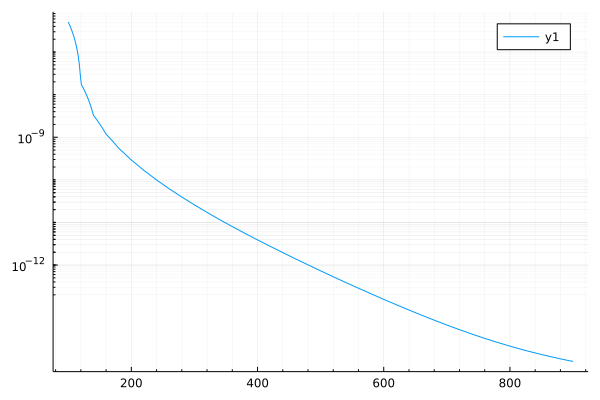

In [13]:
plot(orbit_alts, density_interp.(orbit_alts), yaxis=:log, minorgrid=true)

Aerodynamic torque:
$$\displaystyle \vec g_c = \vec c_p \times \left(\rho V_R^2 A_p \hat V_R\right)$$

In [5]:
# R and V using km for distance, A in m²
# cp in spacecraft body frame
function aerodynamic_torque(R, V, A, cp, C_BN)
    R_mag = norm(R)
    V_mag = norm(V)
    
    V_B = C_BN * V
    V̂ = V_B ./ norm(V_B)
    
    return cp × (density_interp(R_mag - 6378) * (V_mag*1e3)^2 * A * V̂)
end

aerodynamic_torque (generic function with 1 method)

In [28]:
aerodynamic_torque(200, [sqrt(398600 / (6378+250)),0,0], 2.287, [-0.2595, 0.0, 0.0], I(3))

3-element Vector{Float64}:
  0.0
  0.0
 -0.0

## Solar Pressure Torque

In [6]:
function solarpressure_torque(sun_direction, A, cp, C_BN; p=4.5e−6)
    s_B = C_BN * sun_direction
    return cp × (p * A * s_B)
end

solarpressure_torque (generic function with 1 method)

## Gravity Gradient Torque

$$\vec M = 3 \left( \frac{\mu}{R_c^3} \right) \hat A_3 ^\times \vec J_B \hat A_3$$

In [7]:
function gravitygradient_torque(R, JB, C_BN; μ=398600)
    R_mag = norm(R)
    
    #R_B = C_BN * R
    #A3 = R_B ./ norm(R_B)
    
    A3 = -R ./ norm(R)
    
    return  C_BN * (3 * (μ / R_mag^3) * cross_mat(A3) * JB * A3)
end

gravitygradient_torque (generic function with 1 method)

# Visualization

## Setup

In [19]:
re = 6378
μ = 398600

alt = 700

r = [re+alt, 0, 0]
v = [0, sqrt(μ / (re+alt)), 0]

params = [6.6759e-20, 225.0, 5.974e24]
init = [
    r[1],
    r[2],
    r[3],
    v[1],
    v[2],
    v[3],
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
]

tspan = (0.0, (2*π / sqrt(μ)) * (re + alt)^(3/2))
sol_i = diffeq_two_body(init, tspan, params, solver=Vern7(), reltol=1e-9, abstol=1e-9)

length(sol_i)

35

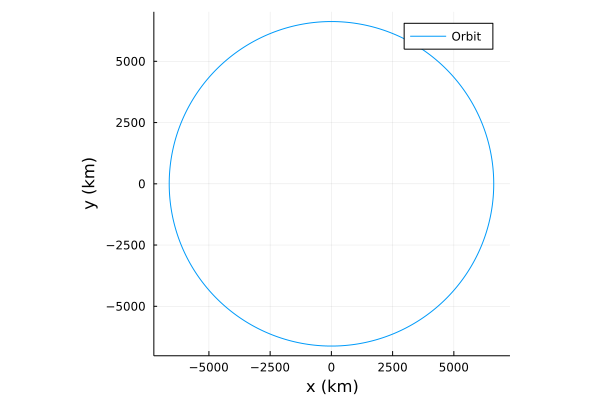

In [9]:
plot(
    sol_i,
    xlabel="x (km)",
    ylabel="y (km)",
    vars=(1,2),
#     size=(800,800),
    dpi=230,
    aspect_ratio=:equal,
    label="Orbit"
)

In [20]:
times = LinRange(0, (2*π / sqrt(μ)) * (re + alt)^(3/2), 500)

orbit_interp = sol_i(times)

orbit_x = orbit_interp[1,1:end]
orbit_y = orbit_interp[2,1:end]
orbit_z = orbit_interp[3,1:end]

orbit_vx = orbit_interp[4,1:end]
orbit_vy = orbit_interp[5,1:end]
orbit_vz = orbit_interp[6,1:end];

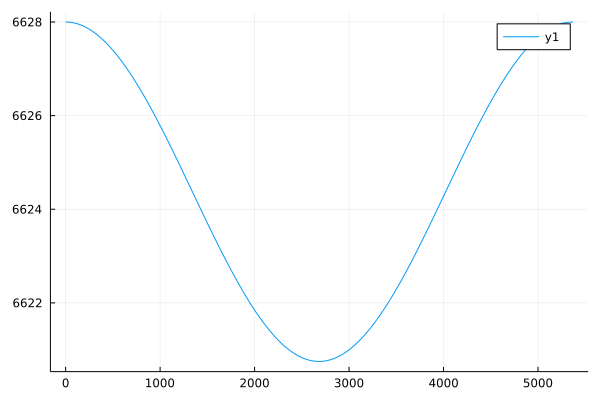

In [11]:
plot(times, sqrt.(orbit_x.^2 + orbit_y.^2))

In [10]:
function ECEF_LVLH(R, V)
    x̂ = R ./ norm(R)
    ŷ = V ./ norm(V)
    ẑ = cross(x̂, ŷ) ./ norm(cross(x̂, ŷ))
    
    return x̂, ŷ, ẑ
end

ECEF_LVLH (generic function with 1 method)

In [11]:
# function C_LVLH_ECEF2(Rx, Ry, Rz, Vx, Vy, Vz)
#     #x, y, z = R
#     x̂l, ŷl, ẑl = ECEF_LVLH([Rx, Ry, Rz], [Vx, Vy, Vz])
    
#     R̂ = [1.0, 0.0, 0.0]
    
#     ϕ = acos(dot(R̂, x̂l))
    
#     if ϕ != 0.0
#         α = cross(R̂, x̂l) ./ norm(cross(R̂, x̂l))
#         return cos(ϕ) .+ (1 - cos(ϕ)) .* α * α' .- sin(ϕ) .* cross_mat(α)
#     else
#         return I(3)
#     end
# end

# function C_LVLH_ECEF(Rx, Ry, Rz)
# #     x, y, z = R
#     δ, λ = ecef2geocentric_latlon(Rx, Ry, Rz)
    
#     return par_3(-λ) * par_2(δ)
# end

function C_LVLH_ECEF(Rx, Ry, Rz, Vx, Vy, Vz)
    o3 = [Rx, Ry, Rz] ./ norm([Rx, Ry, Rz])
    o2 = cross([Rx, Ry, Rz], [Vx, Vy, Vz]) ./ norm(cross([Rx, Ry, Rz], [Vx, Vy, Vz]))
    o1 = cross(o2, o3)

    return [o1 o2 o3]
end

C_LVLH_ECEF (generic function with 1 method)

In [33]:
n=2
ECEF_LVLH([orbit_x[n], orbit_y[n], orbit_z[n]], [orbit_vx[n], orbit_vy[n], orbit_vz[n]])

([0.9999207274302262, 0.012591221362811473, 0.0], [-0.012598115535976659, 0.9999206405935134, 0.0], [0.0, -0.0, 1.0])

In [34]:
C_LVLH_ECEF([orbit_x[n], orbit_y[n], orbit_z[n]], [orbit_vx[n], orbit_vy[n], orbit_vz[n]])

3×3 Matrix{Float64}:
 0.999921  1.01251   0.999921
 0.98733   0.999921  0.999921
 0.999921  0.999921  1.0

## Torque Visualization

In [21]:
# visualizing torques
#C_BN2 = C_LVLH_ECEF2.(orbit_x, orbit_y, orbit_z, orbit_vx, orbit_vy, orbit_vz)
C_BN = C_LVLH_ECEF.(orbit_x, orbit_y, orbit_z, orbit_vx, orbit_vy, orbit_vz)
R = [[orbit_x[i], orbit_y[i], orbit_z[i]] for i in 1:length(orbit_x)]
V = [[orbit_vx[i], orbit_vy[i], orbit_vz[i]] for i in 1:length(orbit_x)]

Am = [[1,1,1] for i in 1:length(orbit_x)]
Tm = magnetic_torque.(Am, R, C_BN)

s = [[-1, 0, 0] for i in 1:length(orbit_x)]
A = [2.287 for i in 1:length(orbit_x)]
cp = [[-0.2595, 0.0, 0.0] for i in 1:length(orbit_x)]
Tsp = solarpressure_torque.(s, A, cp, C_BN)

Jbi = [
    66.4151 0.0 0.0
    0.0 66.4151 0.0
    0.0 0.0 116.163
]

Jb = [Jbi for i in 1:length(orbit_x)]
Tg = gravitygradient_torque.(R, Jb, C_BN)

Ta = aerodynamic_torque.(R, V, A, cp, C_BN);

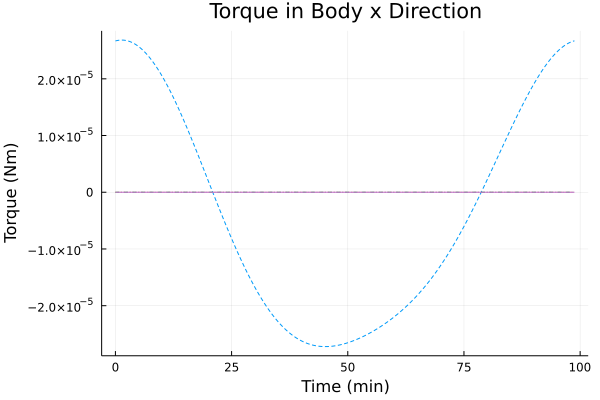

In [22]:
# x axis
px = plot(
    times./60, [Tm[i][1] for i in 1:length(Tm)], 
    label="Magnetic Torque",
    xlabel="Time (min)",
    ylabel="Torque (Nm)",
    title="Torque in Body x Direction",
    legend=nothing,
    linestyle=:dash
)

plot!(times./60, [Tsp[i][1] for i in 1:length(Tsp)], label="Solar Pressure Torque", linestyle=:dot)
plot!(times./60, [Tg[i][1] for i in 1:length(Tg)], label="Gravity Gradient Torque", linestyle=:dashdot)
plot!(times./60, [Ta[i][1] for i in 1:length(Tg)], label="Aerodynamic Torque")

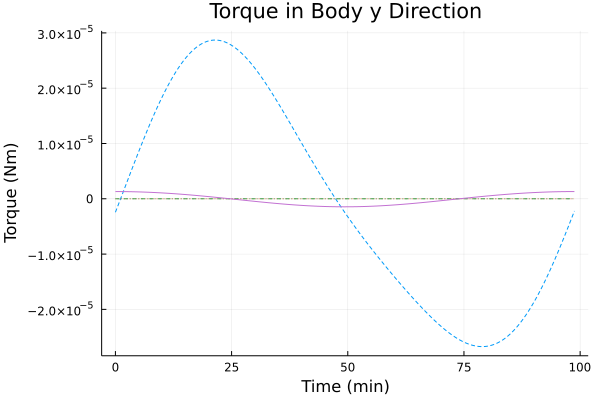

In [23]:
# y axis
py = plot(
    times./60, [Tm[i][2] for i in 1:length(Tm)], 
    label="Magnetic Torque",
    xlabel="Time (min)",
    ylabel="Torque (Nm)",
    title="Torque in Body y Direction",
    legend=nothing,
    linestyle=:dash
)

plot!(times./60, [Tsp[i][2] for i in 1:length(Tsp)], label="Solar Pressure Torque", linestyle=:dot)
plot!(times./60, [Tg[i][2] for i in 1:length(Tg)], label="Gravity Gradient Torque", linestyle=:dashdot)
plot!(times./60, [Ta[i][2] for i in 1:length(Tg)], label="Aerodynamic Torque")

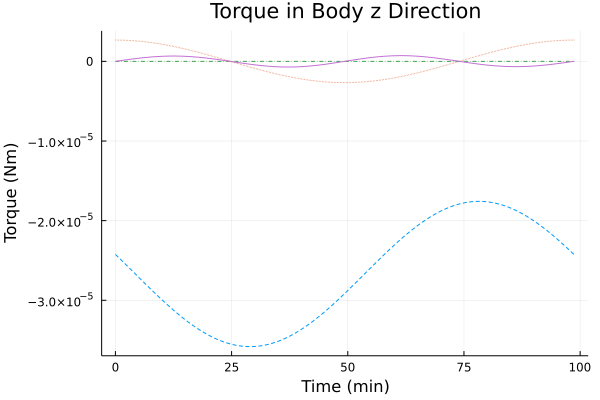

In [24]:
# x axis
pz = plot(
    times./60, [Tm[i][3] for i in 1:length(Tm)], 
    label="Magnetic Torque",
    xlabel="Time (min)",
    ylabel="Torque (Nm)",
    title="Torque in Body z Direction",
    legend=nothing,
    linestyle=:dash
)

plot!(times./60, [Tsp[i][3] for i in 1:length(Tsp)], label="Solar Pressure Torque", linestyle=:dot)
plot!(times./60, [Tg[i][3] for i in 1:length(Tg)], label="Gravity Gradient Torque", linestyle=:dashdot)
plot!(times./60, [Ta[i][3] for i in 1:length(Tg)], label="Aerodynamic Torque")

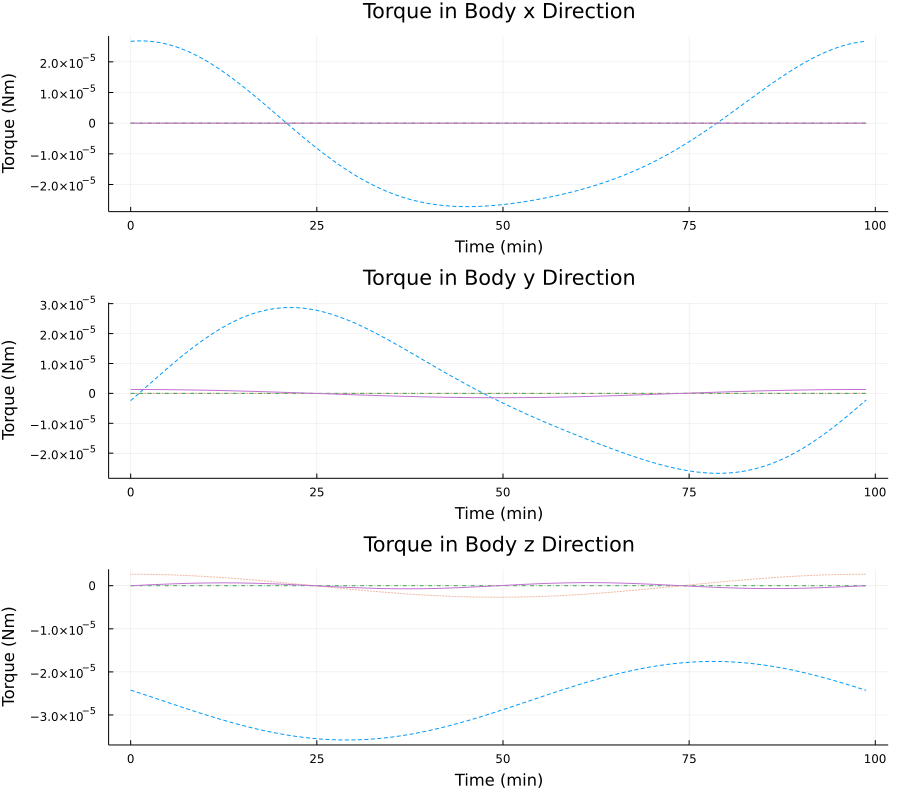

In [25]:
#plot(px, py, pz, layout=(3, 1), size=(900,800), dpi=350, fmt=:png, legend=nothing)
plot(px, py, pz, layout=(3, 1), size=(900,800), dpi=350, legend=nothing)

# Archive

In [14]:
# helper functions
# notation:
# - θ: geocentric colatitude
# - ϕ: east longitude
# - λ: geodetic latitude, λ = π/2 - θ

function cart2geo(cartesian_vector)
    x, y, z = cartesian_vector
    
    return [
        sqrt(x^2 + y^2 + z^2)
        acos(z / sqrt(x^2 + y^2 + z^2))
        atan2(y, x)
    ]
end

function geo2cart(geodetic_vector)
    r, θ, ϕ = geodetic_vector
    
    return [
        r * sin(θ) * cos(ϕ)
        r * sin(θ) * sin(ϕ)
        r * cos(θ)
    ]
end

function R_enu2ecef(geodetic_vector)
    r, θ, ϕ = geodetic_vector
    
    return [
        -sin(ϕ) cos(ϕ) 0
        -cos(θ)*cos(ϕ) -cos(θ)*sin(ϕ) sin(θ)
        sin(θ)*cos(ϕ) sin(θ)*sin(ϕ) cos(θ)
    ]
end

function geo2enu(geodetic_vector)
    r, θ, ϕ = geodetic_vector
    
    return R_enu2ecef(geodetic_vector) * geodetic_vector
end

# latitude = π/2 - θ
function latlonh2geo(latitude, longitude, height)
    f = 1 / 298.257223563
    Req = 6378137.0
    e_squared = 2*f - f^2
    
    ρ = Req / sqrt(1 - e_squared*sin(latitude)^2)
    
    return [
        (ρ + h) * cos(latitude) * cos(longitude)
        (ρ + h) * cos(latitude) * sin(longitude)
        (ρ + h - e_squared * ρ) * sin(latitude)
    ]
end

function pole_unitvec(dir="N")
    @assert dir in ["N","S"] "Invalid direction specified, must be either N or S"
    
    if dir == "N"
        geo_colatitude = rad2deg(9.96)
        longitude = rad2deg(-72.63)
    else dir == "S"
        geo_colatitude = rad2deg(170.31)
        longitude = rad2deg(107.37)
    end
    
    return [
        sin(geo_colatitude) * cos(longitude)
        sin(geo_colatitude) * sin(longitude)
        cos(geo_colatitude)
    ]
end

function centered_dipole()
    ẑ_cd = pole_unitvec()
    ẑ_geo = [1, 0, 0]
    
    ŷ_cd = cross(ẑ_geo, ẑ_cd) ./ norm(cross(ẑ_geo, ẑ_cd))
    x̂_cd = cross(ŷ_cd, ẑ_cd)
    
    return [x̂_cd, ŷ_cd, ẑ_cd]
end

function geo2cd(r_geo)
    x̂_cd, ŷ_cd, ẑ_cd = centered_dipole()
    
    return hcat(x̂_cd, ŷ_cd, ẑ_cd)' * r_geo
end

function local_mag(B⃗, k̂)
    b̂ = B⃗ ./ norm(B⃗)
    
    ê = cross(b̂, k̂) ./ norm(cross(b̂, k̂))
    n̂ = cross(k̂, ê)
    p̂ = cross(ê, b̂)
    
    return ê, n̂, p̂
end

function magnetic_components(B)
    Bx, By, Bz = B
    
    H = sqrt((-Bx)^2 + By^2)
    I = atan(-Bz, H)
    D = atan(By, -Bx)
    
    return H, I, D
end

local_mag (generic function with 1 method)

In [ ]:
function GST() 
end

In [2]:
function mfield_components(r_pos, epoch_GST, t_past_epoch; θm=deg2rad(196.54), ϕm=deg2rad(108.43))
    r̂ = r_pos ./ norm(r_pos)
    re = 6378
    H0 = 30115e-9
    
    ωe = 2 * pi / (24 * 60 * 60)
    αm = epoch_GST + ωe * t_past_epoch + ϕm
    
    d = [
        sin(θm) * cos(αm)
        sin(θm) * sin(αm)
        cos(θm)
    ]
    
    return (3*d' * r̂ * r̂ - d) * re^3 * H0 / (norm(r)^3)
end

mfield_components (generic function with 1 method)

In [3]:
data = [
    1999 6.6147239
    2000 6.5988098
    2001 6.6486056
    2002 6.6326915
    2003 6.6167774
    2004 6.6008633
    2005 6.6506591
    2006 6.6347450
    2007 6.6188309
    2008 6.6029168
    2009 6.6527125
    2010 6.6367984
    2011 6.6208844

]

13×2 Matrix{Float64}:
 1999.0  6.61472
 2000.0  6.59881
 2001.0  6.64861
 2002.0  6.63269
 2003.0  6.61678
 2004.0  6.60086
 2005.0  6.65066
 2006.0  6.63474
 2007.0  6.61883
 2008.0  6.60292
 2009.0  6.65271
 2010.0  6.6368
 2011.0  6.62088

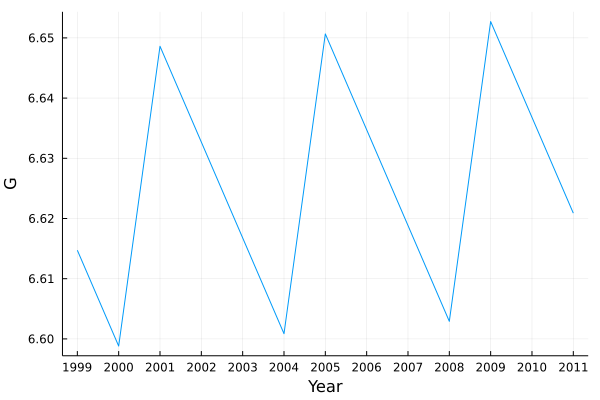

In [4]:
plot(
    data[1:end,1], data[1:end,2], 
    xticks=1999:2011, 
    label="",
    xlabel="Year",
    ylabel="G"
)

In [5]:
# creating curve fit
amplitude = (data[3,2] - data[2,2])/2
period = data[6,1] - data[2,1]

slope = (data[7,2] - data[3,2]) / period
b = data[3,2] - slope * data[3,1]

years = LinRange(1999, 2011, 250)

linear_increase = years.*slope .+ b .- amplitude

f = 1 / period;

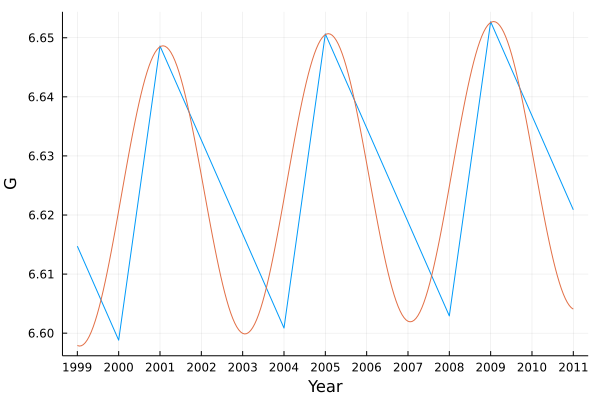

In [6]:
plot(
    data[1:end,1], data[1:end,2], 
    xticks=1999:2011, 
    label="",
    xlabel="Year",
    ylabel="G"
)

sinusoidal = amplitude .* sin.(2*π*f .* years .- 0.1)

curve_fit = linear_increase .+ sinusoidal

plot!(years, curve_fit, label="")